In [1]:
import statistics
import pandas as pd
import matplotlib.pyplot as plt

import nltk
import unidecode
import re

from wordcloud import WordCloud
from nltk import tokenize

# fixa a imagem no notebook
%matplotlib inline

Com base na exploração escolhi o arquivo Train500.csv e o Test.csv como dataset. Eles juntos tem 505 mil tweets!!
* 0 = sentimento NEGATIVO
* 1 = sentimento POSITIVO

#### Busca o dataset

In [2]:
train = pd.read_csv('../portuguese-tweets-for-sentiment-analysis/trainingdatasets/Train500.csv',delimiter=';')
tests = pd.read_csv('../portuguese-tweets-for-sentiment-analysis/testdatasets/Test.csv',delimiter=';')
dataset = pd.concat([train, tests], ignore_index=True)

In [3]:
len(dataset)

505000

In [4]:
dataset.sample(5)

,id,tweet_text,tweet_date,sentiment,query_used
387836,1042313370928644096,Só p quem acordou às 4:00 e não consegue mais ...,Wed Sep 19 07:24:07 +0000 2018,0,:(
231598,1030499519178440704,Feliz que postei running wild no stories e dua...,Fri Aug 17 17:00:05 +0000 2018,1,:)
185622,1032366746773086210,"@Miltinho_GT @justinbiebzw aah tá bem, obrigad...",Wed Aug 22 20:39:47 +0000 2018,1,:)
480425,1039548268546539520,Eu amo eles demais :(((((( https://t.co/DNsJa5...,Tue Sep 11 16:16:35 +0000 2018,0,:(
500589,1029548756159680515,@carlotaloveliz @chibihscg @Mya_Ronda Se ela n...,Wed Aug 15 02:02:06 +0000 2018,1,:)


### Apaga os tweets repetidos

In [5]:
dataset.drop_duplicates(subset='id', keep = False, inplace = True)
dataset.drop_duplicates(subset='tweet_text', keep = False, inplace = True)

### Apaga os tweets nulos

In [6]:
dataset.dropna()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)
...,...,...,...,...,...
504995,1030528364145201153,@ol_cdanilo parece livro de autoajuda :(,Fri Aug 17 18:54:42 +0000 2018,0,:(
504996,1030528418235015168,@tatazoquita aaaaa sinto muito :((,Fri Aug 17 18:54:55 +0000 2018,0,:(
504997,1030528446122930176,To começando a sentir dor de novo e meu irmão ...,Fri Aug 17 18:55:02 +0000 2018,0,:(
504998,1030528453752352769,@ichbintw parece que no dia que toma a vacina ...,Fri Aug 17 18:55:04 +0000 2018,0,:(


### Apaga algumas colunas que não são importantes

In [7]:
dataset.drop(columns = ["id" ,"tweet_date","query_used"], axis = 1 , inplace = True)

In [8]:
print(dataset.sentiment.value_counts())

0    249137
1    248116
Name: sentiment, dtype: int64


### Coloca em lowercase

In [9]:
for index, row in dataset.iterrows():
    dataset.at[index,'tweet_text'] = row['tweet_text'].lower()

### Elimina as stop words

In [10]:
# fazemos o download das stop words mais comuns do português
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("portuguese")
print(stop_words)

['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estiv

[nltk_data] Downloading package stopwords to /home/pedro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
for index, row in dataset.iterrows():
    # regex : retorna apenas as palavras , ":)" , ":(" e ":/"
    # elimina aos pnts de sinalizacao
    words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in words if ws not in stop_words]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

### Retira a acentuação das palavras

In [12]:
for index, row in dataset.iterrows():
    dataset.at[index,'tweet_text'] = unidecode.unidecode(row['tweet_text'])

### Elimina as palavras com @ 
Os nomes de perfis

In [13]:
for index, row in dataset.iterrows():
    # regex : retorna apenas as palavras iniciadas com @
    words_with_arroba = re.findall(r"\@\w+", row['tweet_text'])
    # regex : retorna todas as palavras, :) , :( , :/  e retira as sinalizações
    all_words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in all_words if ws not in words_with_arroba]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

### Elimina palavras com numeros 

exemplo do dataset : '48e433a0-ead1-44f3-9f45-e0e5ea48cfb2'

In [14]:
for index, row in dataset.iterrows():
    # regex : retorna apenas as palavras iniciadas com @
    words_with_numbers = re.findall(r"\S*\d+\S*", row['tweet_text'])
    # regex : retorna todas as palavras, :) , :( , :/  e retira as sinalizações
    all_words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in all_words if ws not in words_with_numbers]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

### Faz a Stemização 
Que é extrair apenas os radicais das palavras, dessa forma conseguimos evitar as contrações e flexões das palavras

In [15]:
nltk.download('rslp')

[nltk_data] Downloading package rslp to /home/pedro/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [16]:
stemmer = nltk.RSLPStemmer()

for index, row in dataset.iterrows():
    #retorna apenas as palavras - eliminando os pnts de sinalizacao
    words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [stemmer.stem(ws) for ws in words]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

### Função - Word Cloud

In [17]:
def word_cloud(data):
    text = [str(text) for text in data]

    # um texto enorme, com todas as resenhas
    all_ = ' '.join(text)
    cloud_words = WordCloud(
        width = 500 , height = 300 , 
               max_font_size = 100,
                           collocations = False).generate(all_)


    plt.figure(figsize = (10,8))
    plt.imshow(cloud_words , interpolation = 'bilinear')
    plt.axis("off")
    plt.show()

### Função - Contador de tokens

In [18]:
def count_tokens(data):
    text = [str(text) for text in data]
    all_ = ''
    all_ = ' '.join(text)

    tokenizador = tokenize.WhitespaceTokenizer()
    tokens = tokenizador.tokenize(all_)

    frequencia = nltk.FreqDist(tokens)

    df_frequencia = pd.DataFrame({
        "Palavra" : list(frequencia.keys()),
        "Frequência" : list(frequencia.values())
    })

    ## mostra as palavras de maior frequencia
    most_frequency = df_frequencia.nlargest(
        columns = "Frequência" , 
        n = 10)

    return most_frequency

# Analise

In [19]:
tweets_positivos = dataset.query('sentiment == 1')
tweets_negativos = dataset.query('sentiment == 0')

## Analise dos tweets positivos

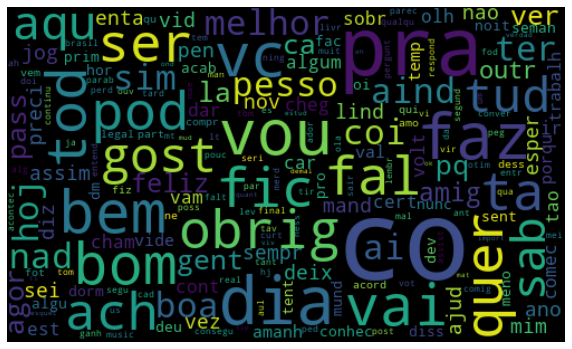

In [20]:
word_cloud(tweets_positivos.tweet_text)

In [21]:
count_tokens(tweets_positivos.tweet_text)

,Palavra,Frequência
4,:),202105
26,t,57359
25,:/,57357
27,co,57149
24,http,56944
34,d,30077
123,pra,24946
75,p,18625
148,dia,15915
13,faz,14670


## Analise dos tweets negativos

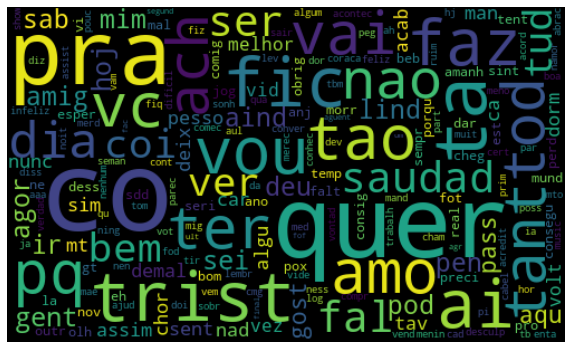

In [22]:
word_cloud(tweets_negativos.tweet_text)

In [23]:
count_tokens(tweets_negativos.tweet_text)

,Palavra,Frequência
1,:(,249248
51,:/,41083
52,t,41037
53,co,40806
50,http,40694
10,quer,32313
79,to,26314
25,pra,25600
93,q,17274
29,ta,16200


## Vamos apagar as words que aparecem frequentemente nas 2 classes de sentimento

In [24]:
# funcao que retorna as N palavras mais frequentes de um texto
def get_n_most_frequency(n,data):
    text = [str(text) for text in data]
    all_ = ''
    all_ = ' '.join(text)

    tokenizador = tokenize.WhitespaceTokenizer()
    tokens = tokenizador.tokenize(all_)

    frequencia = nltk.FreqDist(tokens)

    df_frequencia = pd.DataFrame({
        "Palavra" : list(frequencia.keys()),
        "Frequência" : list(frequencia.values())
    })

    ## mostra as palavras de maior frequencia
    most_frequency = df_frequencia.nlargest(
        columns = "Frequência" , 
        n = n)

    list_n_most_frequency = most_frequency.Palavra
    return list(list_n_most_frequency)

In [25]:
most_frequency_positivo = get_n_most_frequency(10,tweets_positivos.tweet_text)
most_frequency_negativo = get_n_most_frequency(10,tweets_negativos.tweet_text)
equal = list(set(most_frequency_positivo) & set(most_frequency_negativo))
equal

['http', 't', 'co', 'pra', ':/']

In [26]:
for index, row in dataset.iterrows():
    words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in words if ws not in equal]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

In [27]:
tweets_positivos = dataset.query('sentiment == 1')
tweets_negativos = dataset.query('sentiment == 0')

In [28]:
count_tokens(tweets_positivos.tweet_text)

,Palavra,Frequência
4,:),202105
30,d,30077
71,p,18625
143,dia,15915
13,faz,14670
297,q,14559
12,vou,14164
48,vc,13168
217,bem,12854
232,bom,11889


In [29]:
count_tokens(tweets_negativos.tweet_text)

,Palavra,Frequência
1,:(,249248
10,quer,32313
74,to,26314
88,q,17274
28,ta,16200
20,fic,13894
21,trist,13874
31,ai,13175
57,vou,12479
64,faz,12448


## Numero médio de palavras por tweet

In [30]:
buf = []
for index, row in dataset.iterrows():
    buf.append(len(row['tweet_text'].split()))

statistics.mean(buf)

8.069095611288418

In [31]:
max(buf)

54

In [32]:
min(buf)

0

### Apagar tweet com conteudo de tamanho zero

In [33]:
for index, row in dataset.iterrows():
    tam = len(row['tweet_text'].split())
    if tam == 0:
        dataset.drop(index, inplace=True)

### Apaga do tweet letras isoladas
Exemplo : ola c t vc

In [34]:
for index, row in dataset.iterrows():
    only_letter = re.findall(r"\b[a-z]\b", row['tweet_text'])
    words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in words if ws not in only_letter]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

### Apagar palavras que são composta pela mesma letra
Exemplo : aaaaaaaaaa kkkkkkk rrrrrr uuuuuuuu uuuuuuuuu 

In [35]:
for index, row in dataset.iterrows():
    word_same_letter = re.findall(
        r"\ba{2,}\b|\bb{2,}\b|\bc{2,}\b|\bd{2,}\b|\be{2,}\b|\bf{2,}\b|\bg{2,}\b|\bh{2,}\b|\bi{2,}\b|\bj{2,}\b|\bk{2,}\b|\bl{2,}\b|\bm{2,}\b|\bn{2,}\b|\bo{2,}\b|\bp{2,}\b|\bq{2,}\b|\br{2,}\b|\bs{2,}\b|\bt{2,}\b|\bu{2,}\b|\bv{2,}\b|\bw{2,}\b|\bx{2,}\b|\by{2,}\b|\bz{2,}\b",
        row['tweet_text'])
    words = re.findall(r"([\w']+|:\(|:-\(|:-\)|:\)|:\/|\@\w+)", row['tweet_text'])
    temp = [ws for ws in words if ws not in word_same_letter]
    dataset.at[index,'tweet_text'] = ' '.join(temp)

In [36]:
dataset.head(5)

,tweet_text,sentiment
0,pesso cert val azeved :),1
1,mim precis contrari :) vem chuv vem boa dispos...,1
2,vou faz vide hoj pens fal pouc sobr nov met cs...,1
3,ame tant polaroid sei express quant to apaixon...,1
4,valoriz coraca menin vc difer fac sorr ter cer...,1


In [37]:
dataset.to_csv(r'treated_dataset.csv',index=False)